L251202103354F357373F37_PH06.fits: Loaded 755834 photons.
L251202103354F357373F37_PH02.fits: Loaded 1074939 photons.
L251202103354F357373F37_PH01.fits: Loaded 901350 photons.
L251202103354F357373F37_PH03.fits: Loaded 878247 photons.
L251202103354F357373F37_PH00.fits: Loaded 815203 photons.
L251202103354F357373F37_PH05.fits: Loaded 742757 photons.
L251202103354F357373F37_PH04.fits: Loaded 756630 photons.
Total Photons: 5924960


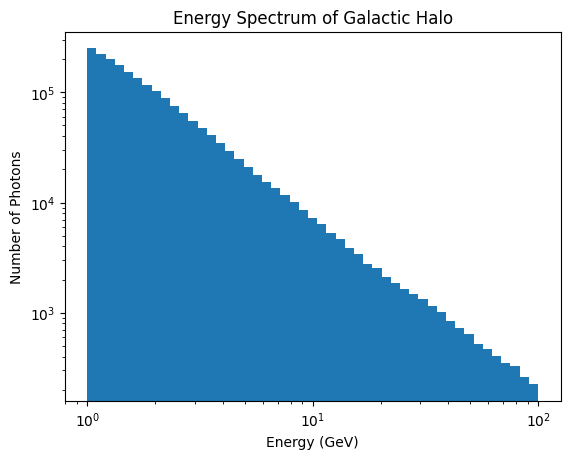

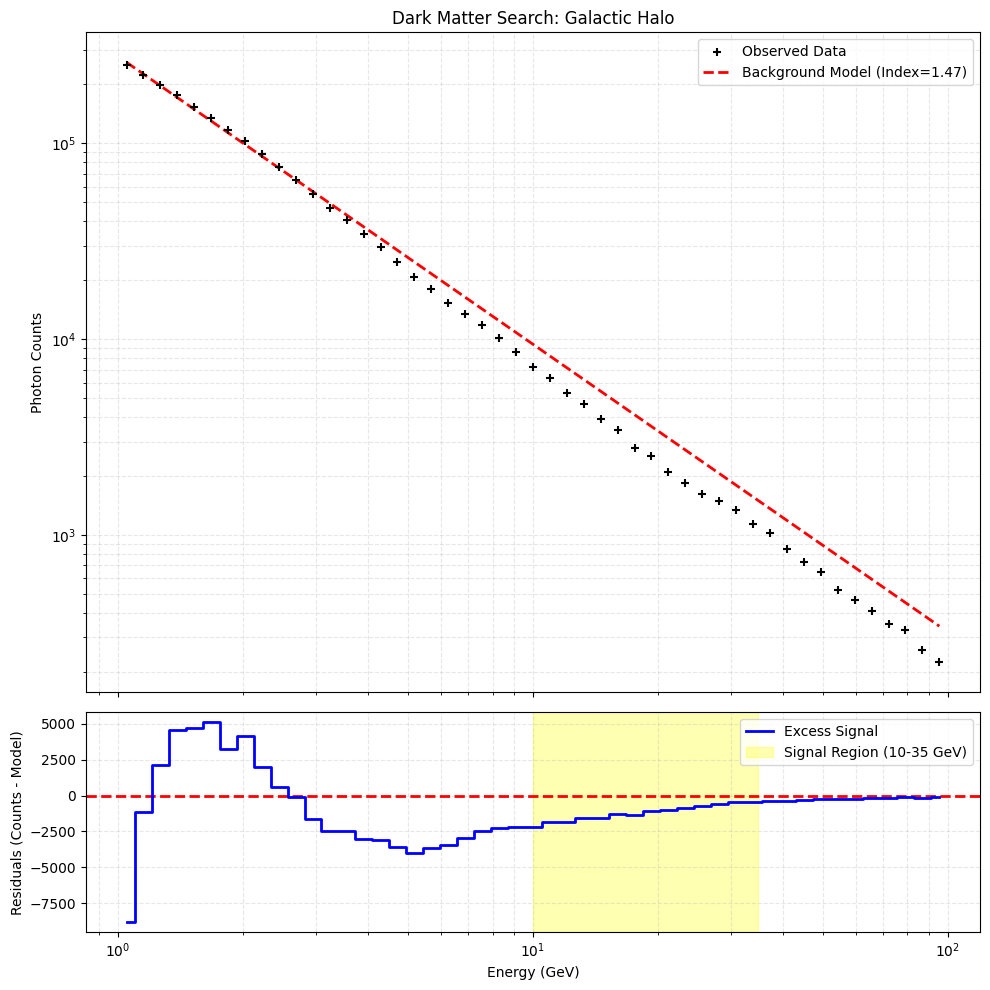

In [43]:
import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

mission_start_date = datetime.datetime(2001, 1, 1, 0, 0, 0, tzinfo=datetime.timezone.utc)
directory = "Data"
all_L = []
all_B = []
all_E = []
all_T = []

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".fits"):
        full_path = os.path.join(directory, filename)

        try:
            with fits.open(full_path) as hdul:
                data = hdul["EVENTS"].data
                all_L.append(data["L"])
                all_B.append(data["B"])
                all_E.append(data["ENERGY"])
                all_T.append(data["TIME"])
                print(f"{filename}: Loaded {len(data["L"])} photons.")
        except Exception as e:
            print(f"Could not open {filename}: {e}")

glon = np.concatenate(all_L)
glat = np.concatenate(all_B)
energy = np.concatenate(all_E)
time = np.concatenate(all_T)
print(f"Total Photons: {len(glon)}")

mask = np.abs(glat) > 5
halo_energies_gev = energy[mask] / 1000

my_bins = np.geomspace(1, 100, 50)
plt.yscale("log")
plt.xscale("log")

plt.xlabel("Energy (GeV)")
plt.ylabel("Number of Photons")
plt.title(f"Energy Spectrum of Galactic Halo")

plt.grid(True, which="both", ls="--", alpha=0.5)
counts, bin_edges, _ = plt.hist(halo_energies_gev, bins=my_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
def background_model(energy, A, gamma):
    return A * (energy ** (-gamma))
fit_mask = (bin_centers < 10) | (bin_centers > 35)
x_sidebands = bin_centers[fit_mask]
y_sidebands = counts[fit_mask]
from scipy.optimize import curve_fit
popt, pcov = curve_fit(background_model, x_sidebands, y_sidebands, p0=[1e5, 2.5])
# print(f"Best Fit Amplitude: {popt[0]:.2e}")
# print(f"Best Fit Slope: {popt[1]:.2f}")

model_counts = background_model(bin_centers, *popt)
residuals = counts - model_counts

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
ax1.scatter(bin_centers, counts, color='black', marker='+', label='Observed Data', zorder=5)
ax1.plot(bin_centers, model_counts, color='red', linestyle='--', linewidth=2, label=f'Background Model (Index={popt[1]:.2f})')

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel('Photon Counts')
ax1.set_title('Dark Matter Search: Galactic Halo')
ax1.legend()
ax1.grid(True, which="both", ls="--", alpha=0.3)

ax2.axhline(0, color='red', linestyle='--', linewidth=2) # The "Zero" line
ax2.step(bin_centers, residuals, where='mid', color='blue', linewidth=2, label='Excess Signal')

ax2.axvspan(10, 35, color='yellow', alpha=0.3, label='Signal Region (10-35 GeV)')

ax2.set_xscale('log')
ax2.set_xlabel('Energy (GeV)')
ax2.set_ylabel('Residuals (Counts - Model)')
ax2.grid(True, which="both", ls="--", alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()